**Librerías**

In [1]:
!pip install pykrige

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.9 MB/s eta 0:00:00


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 58.9 MB/s eta 0:00:00


**Ejecución de ,los métodos IDW y RF**

In [3]:

#Librerías
import os, math, json, warnings, gc
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.ops import unary_union
from shapely.affinity import translate
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling, transform_geom
from pyproj import CRS

# Modelos
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from joblib import dump
from xgboost import XGBRegressor

# Visual
from matplotlib import cm
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", message="The 'unary_union' attribute is deprecated")

# ====================== Cargar datos ======================
CSV_PATH     = "eggs_data.csv"
MERIDA_SHP   = "2024_31050_L22102025_2228.shp"
YUCATAN_SHP  = None               # opcional: shapefile estatal para conteo por municipio

CSV_CRS      = None               # Si ya se sabe cual es el CRS ponerlo aquí, si no ponerle None


RUN_IDW      = True
RUN_KRIGING  = False              # Demasiado pesado, omitirlo en caso de que no se cuente con RAM
RUN_RF       = True
RUN_XGB      = True
RUN_UNION    = True
RUN_METRICS  = True

# Resolución
RES_METERS        = 250           # resolución para IDW/RF (m)
RES_XGB_METERS    = 100           # resolución para XGBoost (m)
MAX_GRID_CELLS_KRIG = 4.0e5

# IDW
IDW_POWER    = 2.0
IDW_K        = 8
MIN_PTS_IDW  = 1

# Kriging
KRIGING_VARIOMODEL = "linear"
MIN_PTS_KRG  = 3

# RF
MIN_PTS_RF   = 5
RF_TREES     = 200
RF_JOBS      = 2
RF_CV_FOLDS  = 5

# XGB
K_FOLDS_XGB = 5
XGB_PARAMS = dict(
    n_estimators=1000, learning_rate=0.05, max_depth=8,
    subsample=0.8, colsample_bytree=0.8,
    reg_lambda=1.0, objective="reg:squarederror",
    tree_method="hist", random_state=42, n_jobs=-1
)

# Unión (color)
COLORMAP_NAME     = "RdYlGn"
REVERSED          = False
STRETCH_METHOD    = "percentile"  # "percentile" o "minmax"
PCT_LOW, PCT_HIGH = 2, 98
# ========================================================


# ------------------- UTILIDADES -------------------
def bounds_str(gdf):
    b = gdf.total_bounds
    return f"[{b[0]:.6f}, {b[1]:.6f}, {b[2]:.6f}, {b[3]:.6f}]"

def ensure_projected(crs_poly):
    """CRS proyectado en metros (UTM 16N para Yucatán)."""
    crs_poly = CRS.from_user_input(crs_poly) if crs_poly else CRS.from_epsg(4326)
    if crs_poly.is_projected:
        return crs_poly
    return CRS.from_epsg(32616)

def guess_csv_crs(df):
    """Heurística para adivinar CRS del CSV."""
    x, y = df["x"].astype(float), df["y"].astype(float)
    if x.between(-180, 180).all() and y.between(-90, 90).all():
        return CRS.from_epsg(4326)  # grados
    if x.abs().median() > 1e4 and y.abs().median() > 1e4:
        return None  # parece UTM
    return CRS.from_epsg(4326)

def try_point_gdf(df, crs_candidate):
    return gpd.GeoDataFrame(df.copy(),
                            geometry=gpd.points_from_xy(df["x"], df["y"]),
                            crs=crs_candidate)

def try_variants_into_polygon(df_raw, poly_gdf, csv_crs_user=None):
    """
    Prueba variantes (as_is/swap) y CRS candidatos para maximizar puntos dentro del polígono.
    Retorna: (gdf_mejor, tag, n_inside), attempts
    """
    attempts = []
    poly_crs = poly_gdf.crs or CRS.from_epsg(4326)
    guessed = guess_csv_crs(df_raw) if csv_crs_user is None else CRS.from_user_input(csv_crs_user)

    candidates = []
    if guessed:
        candidates.append(("as_is", guessed, False))
        candidates.append(("swap_xy", guessed, True))
        if guessed.to_epsg() == 4326:
            for utm_epsg in (32615, 32616, 32617):
                candidates.append((f"as_is_utm{utm_epsg}", CRS.from_epsg(utm_epsg), False))
                candidates.append((f"swap_xy_utm{utm_epsg}", CRS.from_epsg(utm_epsg), True))
    else:
        for utm_epsg in (32615, 32616, 32617):
            candidates.append((f"as_is_utm{utm_epsg}", CRS.from_epsg(utm_epsg), False))
            candidates.append((f"swap_xy_utm{utm_epsg}", CRS.from_epsg(utm_epsg), True))

    best = None
    union = unary_union(poly_gdf.geometry)
    for tag, crs_cand, swap in candidates:
        df = df_raw.copy()
        if swap:
            df["x"], df["y"] = df_raw["y"].values, df_raw["x"].values
        try:
            gdf = try_point_gdf(df, crs_cand).to_crs(poly_crs)
        except Exception as e:
            attempts.append((tag, f"ERR:{e}", 0))
            continue
        inside = gdf[gdf.geometry.within(union)]
        attempts.append((tag, str(crs_cand), len(inside)))
        if best is None or len(inside) > best[2]:
            best = (gdf, tag, len(inside))
    return best, attempts

def raster_mask_from_polygon(polyg_gdf, out_shape, transform, invert=False):
    shapes = [(geom, 1) for geom in polyg_gdf.geometry]
    mask = rasterize(
        shapes,
        out_shape=out_shape,
        transform=transform,
        fill=0,
        all_touched=False,
        dtype="uint8"
    ).astype(bool)
    return ~mask if invert else mask

def save_raster_fast(array2d, transform, crs, out_path, nodata=np.nan):
    profile = {
        "driver": "GTiff",
        "height": array2d.shape[0],
        "width": array2d.shape[1],
        "count": 1,
        "dtype": rasterio.float32,
        "crs": crs,
        "transform": transform,
        "nodata": nodata,
        "tiled": True,
        "blockxsize": 256,
        "blockysize": 256,
        "compress": "LZW",
        "BIGTIFF": "IF_SAFER",
    }
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(array2d.astype(np.float32), 1)

def idw_grid(xy, values, grid_x, grid_y, power=2.0, k=8):
    from scipy.spatial import cKDTree
    if len(xy) == 0:
        raise ValueError("IDW: no hay puntos.")
    k = max(1, min(k, len(xy)))
    tree = cKDTree(xy)
    gx, gy = np.meshgrid(grid_x, grid_y)
    grid_pts = np.vstack([gx.ravel(), gy.ravel()]).T
    dist, idx = tree.query(grid_pts, k=k)
    dist = np.where(dist == 0, 1e-12, dist)
    w = 1.0 / (dist ** power)
    v = np.sum(w * values[idx], axis=1) / np.sum(w, axis=1)
    return v.reshape(gx.shape)

def spatial_join_count(points_gdf, yucatan_shp_path, out_csv="puntos_por_municipio.csv"):
    try:
        mpios = gpd.read_file(yucatan_shp_path)
        if mpios.crs != points_gdf.crs:
            mpios = mpios.to_crs(points_gdf.crs)
        joined = gpd.sjoin(points_gdf, mpios, how="left", predicate="within")
        name_cols = [c for c in joined.columns if c.lower() in ("nom_mun","nombre","name","municipio","nom_mpio","nom_mun")]
        name_col = name_cols[0] if name_cols else None
        if name_col is None:
            candidate = [c for c in mpios.columns if mpios[c].dtype == object]
            name_col = candidate[0] if candidate else mpios.columns[-1]
            joined = joined.rename(columns={name_col: "municipio"})
            name_col = "municipio"
        counts = joined.groupby(name_col).size().reset_index(name="n_puntos").sort_values("n_puntos", ascending=False)
        counts.to_csv(out_csv, index=False)
        return out_csv, counts["n_puntos"].sum()
    except Exception:
        return None, 0

def _get_cmap():
    name = COLORMAP_NAME
    if REVERSED and not name.endswith("_r"):
        name = name + "_r"
    return cm.get_cmap(name, 256)

def _calc_vmin_vmax(arr):
    vals = arr[np.isfinite(arr)]
    if vals.size == 0:
        return 0.0, 1.0
    if STRETCH_METHOD == "percentile":
        vmin = float(np.nanpercentile(vals, PCT_LOW))
        vmax = float(np.nanpercentile(vals, PCT_HIGH))
    else:
        vmin = float(np.nanmin(vals))
        vmax = float(np.nanmax(vals))
    if vmin == vmax:
        vmax = vmin + 1.0
    return vmin, vmax

def _save_rgb_geotiff(array2d, transform, crs, out_path):
    mask_valid = np.isfinite(array2d)
    vmin, vmax = _calc_vmin_vmax(array2d)
    cmap = _get_cmap()
    normed = (np.clip(array2d, vmin, vmax) - vmin) / (vmax - vmin)
    rgba = cmap(normed)  # HxWx4
    r = (rgba[...,0]*255).astype("uint8")
    g = (rgba[...,1]*255).astype("uint8")
    b = (rgba[...,2]*255).astype("uint8")
    r[~mask_valid] = 255; g[~mask_valid] = 255; b[~mask_valid] = 255
    profile = {
        "driver": "GTiff",
        "height": array2d.shape[0],
        "width": array2d.shape[1],
        "count": 3,
        "dtype": "uint8",
        "crs": crs,
        "transform": transform,
        "tiled": True,
        "blockxsize": 256,
        "blockysize": 256,
        "compress": "LZW",
        "BIGTIFF": "IF_SAFER"
    }
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(r, 1); dst.write(g, 2); dst.write(b, 3)

def _save_png(array2d, out_png):
    vmin, vmax = _calc_vmin_vmax(array2d)
    plt.figure(figsize=(8, 8)); plt.axis("off")
    plt.imshow(array2d, cmap=_get_cmap(), vmin=vmin, vmax=vmax)
    plt.tight_layout(pad=0)
    plt.savefig(out_png, dpi=200, bbox_inches="tight", pad_inches=0)
    plt.close()

def extract_raster_values_at_points(raster_path, points_gdf):
    try:
        with rasterio.open(raster_path) as src:
            points_proj = points_gdf.to_crs(src.crs)
            coords = [(x, y) for x, y in zip(points_proj.geometry.x, points_proj.geometry.y)]
            values = [value[0] for value in src.sample(coords)]
            return np.array(values, dtype="float32")
    except Exception as e:
        print(f"Error extracting raster values from {raster_path}: {e}")
        return None


# ------------------- RF core -------------------
def rf_fit_predict(points_proj_gdf, poly_proj_gdf, value_col, res_m=250, year_col="year", week_col="week"):
    df = points_proj_gdf.copy()
    df["X"] = df.geometry.x.values
    df["Y"] = df.geometry.y.values
    feats = ["X", "Y"]
    if year_col in df.columns: feats.append(year_col)
    if week_col in df.columns: feats.append(week_col)

    if len(df) < MIN_PTS_RF:
        return None, None, {"rmse": None, "mae": None, "r2": None, "note": f"RF omitido: <{MIN_PTS_RF} muestras"}, None

    X = df[feats].astype(float).values
    y = df[value_col].astype(float).values

    folds = min(RF_CV_FOLDS, max(2, len(df)//2))
    base_rf = RandomForestRegressor(
        n_estimators=RF_TREES, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        max_features="sqrt", n_jobs=RF_JOBS, random_state=42
    )
    try:
        yhat_cv = cross_val_predict(base_rf, X, y, cv=folds, n_jobs=1)
        rmse = float(np.sqrt(mean_squared_error(y, yhat_cv)))
        mae  = float(mean_absolute_error(y, yhat_cv))
        r2   = float(r2_score(y, yhat_cv))
    except Exception as e:
        return None, None, {"rmse": None, "mae": None, "r2": None, "note": f"RF CV falló: {e}"}, None

    rf = RandomForestRegressor(
        n_estimators=RF_TREES, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        max_features="sqrt", n_jobs=RF_JOBS, random_state=42
    )
    rf.fit(X, y)

    minx, miny, maxx, maxy = poly_proj_gdf.total_bounds
    nx = int(math.ceil((maxx - minx)/res_m))
    ny = int(math.ceil((maxy - miny)/res_m))
    grid_x = np.linspace(minx + res_m/2, minx + res_m/2 + (nx-1)*res_m, nx)
    grid_y = np.linspace(maxy - res_m/2, maxy - res_m/2 - (ny-1)*res_m, ny)

    gx, gy = np.meshgrid(grid_x, grid_y)
    grid_df = pd.DataFrame({"X": gx.ravel(), "Y": gy.ravel()})
    if "year" in feats: grid_df["year"] = df["year"].mode().iloc[0]
    if "week" in feats: grid_df["week"] = df["week"].mode().iloc[0]

    Z = rf.predict(grid_df[feats].values).reshape(gx.shape)
    transform = from_origin(minx, maxy, res_m, res_m)
    return Z, transform, {"rmse": rmse, "mae": mae, "r2": r2, "note": "OK"}, rf


# ------------------- XGB core -------------------
def xgb_cv_and_map(points_gdf, aoi_gdf, value_col="eggs", res_m=100, k_folds=5):
    proj = ensure_projected(aoi_gdf.crs)
    aoi_p = aoi_gdf.to_crs(proj)
    pts_p = points_gdf.to_crs(proj)

    pts_p["X"], pts_p["Y"] = pts_p.geometry.x, pts_p.geometry.y
    feats = ["X","Y"] + [c for c in ["year","week"] if c in pts_p.columns]
    data = pts_p.dropna(subset=feats+[value_col])
    X, y = data[feats].astype(float).values, data[value_col].astype(float).values

    if len(data) < 2:
        raise RuntimeError("XGBoost: muy pocos puntos para CV.")

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    model = XGBRegressor(**XGB_PARAMS)
    ycv = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)

    rmse = float(np.sqrt(mean_squared_error(y, ycv)))
    mae  = float(mean_absolute_error(y, ycv))
    r2   = float(r2_score(y, ycv))

    pd.DataFrame({"y_true": y, "y_pred_cv": ycv, "residuo": y - ycv}).to_csv("cv_predictions.csv", index=False)
    json.dump({"rmse": rmse, "mae": mae, "r2": r2, "features": feats}, open("xgb_cv_report.json","w"), indent=2)

    # train final
    xgb = XGBRegressor(**XGB_PARAMS)
    xgb.fit(X, y)

    minx, miny, maxx, maxy = aoi_p.total_bounds
    nx, ny = math.ceil((maxx-minx)/res_m), math.ceil((maxy-miny)/res_m)
    gx = np.linspace(minx+res_m/2, maxx-res_m/2, nx)
    gy = np.linspace(maxy-res_m/2, miny+res_m/2, ny)
    GX, GY = np.meshgrid(gx, gy)
    grid = pd.DataFrame({"X": GX.ravel(), "Y": GY.ravel()})
    if "year" in feats: grid["year"] = data["year"].mode().iloc[0]
    if "week" in feats: grid["week"] = data["week"].mode().iloc[0]
    Z = xgb.predict(grid[feats].values).reshape(GX.shape)
    transform = from_origin(minx, maxy, res_m, res_m)

    save_raster_fast(Z, transform, proj.to_wkt(), "pred_XGB_100m_Merida.tif")
    # recorte exacto
    with rasterio.open("pred_XGB_100m_Merida.tif") as src:
        out_img, out_tr = mask(src, aoi_p.geometry, crop=True)
        meta = src.meta.copy()
        meta.update(height=out_img.shape[1], width=out_img.shape[2], transform=out_tr)
        with rasterio.open("pred_XGB_100m_Merida.tif","w",**meta) as dst:
            dst.write(out_img)

    return {"rmse": rmse, "mae": mae, "r2": r2, "note": "OK"}


# ------------------- MAIN -------------------
def main():
    assert os.path.exists(MERIDA_SHP), f"No encuentro {MERIDA_SHP}"
    assert os.path.exists(CSV_PATH),   f"No encuentro {CSV_PATH}"

    # 1) Polígono de Mérida
    merida = gpd.read_file(MERIDA_SHP)
    if merida.crs is None:
        merida.set_crs(epsg=4326, inplace=True)
    print(f"Mérida CRS: {merida.crs} | bounds: {bounds_str(merida)}")

    # 2) CSV sin procesar y limpieza
    df_raw = pd.read_csv(CSV_PATH)
    df_raw = df_raw.loc[:, ~df_raw.columns.str.contains(r"^Unnamed")]
    for col in ("x","y","eggs"):
        if col not in df_raw.columns:
            raise RuntimeError(f"Falta columna '{col}' en {CSV_PATH}.")

    # 3) Variante que deje más puntos dentro del polígono
    best, attempts = try_variants_into_polygon(df_raw, merida, csv_crs_user=CSV_CRS)
    if best is None:
        raise RuntimeError("No pude construir GeoDataFrame a partir del CSV.")
    gdf, tag_choice, n_inside = best
    gdf = gdf.reset_index(drop=True)
    gdf.to_file("ovitrampas_Merida.shp")
    print("---- Variantes probadas (tag, crs, inside) ----")
    for tag, crs_txt, n in attempts:
        print(f"  {tag:18s} | {crs_txt:20s} | inside={n}")
    print(f"Elegida: {tag_choice} | inside={n_inside}")
    print(f"Bounds puntos (CRS de Mérida): {bounds_str(gdf)}")

    # 4) Clip a Mérida (y corrección opcional de lat si no cae dentro)
    merida_union = unary_union(merida.geometry)
    gdf_clip = gdf[gdf.geometry.within(merida_union)]
    gdf_clip.to_file("ovitrampas_clip_Merida.shp")
    print(f"Puntos dentro de Mérida: {len(gdf_clip)}")

    applied_shift, lat_shift = False, None
    if gdf_clip.empty:
        px_minx, px_miny, px_maxx, px_maxy = gdf.total_bounds
        tc_minx, tc_miny, tc_maxx, tc_maxy = merida.total_bounds
        denom = max(px_maxx - px_minx, 1e-9)
        overlap_x = max(0.0, min(px_maxx, tc_maxx) - max(px_minx, tc_minx)) / denom
        lat_pts  = gdf.geometry.y.median()
        lat_mda  = merida.geometry.unary_union.centroid.y
        lat_shift = lat_mda - lat_pts

        print(f"Diagnóstico desplazamiento: overlap_lon={overlap_x:.2f}, lat_shift≈{lat_shift:.4f}°")
        if overlap_x >= 0.5 and 0.3 <= abs(lat_shift) <= 1.0:
            gdf_shift = gdf.copy()
            gdf_shift["geometry"] = gdf_shift.geometry.apply(lambda geom: translate(geom, xoff=0.0, yoff=lat_shift))
            gdf_clip2 = gdf_shift[gdf_shift.geometry.within(merida_union)]
            print(f"Tras aplicar shift: puntos dentro de Mérida = {len(gdf_clip2)}")
            if not gdf_clip2.empty:
                gdf = gdf_shift.reset_index(drop=True)
                gdf_clip = gdf_clip2.reset_index(drop=True)
                gdf.to_file("ovitrampas_Merida.shp")
                gdf_clip.to_file("ovitrampas_clip_Merida.shp")
                tag_choice += " + lat_shift"
                applied_shift = True

    if gdf_clip.empty:
        print("Aviso: no hay puntos dentro de Mérida tras correcciones. Se omiten interpolaciones.")
        with open("reporte_pipeline.txt", "w", encoding="utf-8") as f:
            f.write("Sin puntos dentro de Mérida. Verifica CRS/coords.\n")
            f.write("Intentos CSV->Mérida:\n")
            for tag, crs_txt, n in attempts:
                f.write(f" - {tag:18s} | {crs_txt:20s} | inside={n}\n")
        if YUCATAN_SHP:
            out_csv, total = spatial_join_count(gdf, YUCATAN_SHP, out_csv="puntos_por_municipio.csv")
            if out_csv:
                print(f">> Conteo por municipio: {out_csv} (total puntos: {total})")
        return

    # 5) Proyección de trabajo y grilla base
    proj = ensure_projected(merida.crs)
    merida_p = merida.to_crs(proj)
    gdf_p    = gdf_clip.to_crs(proj)

    minx, miny, maxx, maxy = merida_p.total_bounds
    res = RES_METERS
    nx = int(math.ceil((maxx - minx)/res))
    ny = int(math.ceil((maxy - miny)/res))
    grid_x = np.linspace(minx + res/2, minx + res/2 + (nx-1)*res, nx)
    grid_y = np.linspace(maxy - res/2, maxy - res/2 - (ny-1)*res, ny)
    transform = from_origin(minx, maxy, res, res)
    mask_in = raster_mask_from_polygon(merida_p, out_shape=(ny, nx), transform=transform, invert=False)

    xy   = np.c_[gdf_p.geometry.x.values, gdf_p.geometry.y.values]
    vals = gdf_p["eggs"].astype(float).values

    # 6) IDW
    did_idw = False
    if RUN_IDW and len(xy) >= MIN_PTS_IDW:
        try:
            idw_arr = idw_grid(xy, vals, grid_x, grid_y, power=IDW_POWER, k=IDW_K)
            idw_arr = np.where(mask_in, idw_arr, np.nan)
            save_raster_fast(idw_arr, transform, proj.to_wkt(), "pred_IDW_Merida.tif")
            did_idw = True
            del idw_arr; gc.collect()
        except Exception as e:
            print(f"IDW omitido: {e}")
    else:
        print(f"IDW omitido (RUN_IDW={RUN_IDW} o puntos<{MIN_PTS_IDW}).")

    # 7) Kriging (opcional)
    did_krig = False
    if RUN_KRIGING and len(xy) >= MIN_PTS_KRG and np.std(vals) > 0:
        total_cells = nx * ny
        if total_cells > MAX_GRID_CELLS_KRIG:
            print(f"Kriging omitido: malla {total_cells:,} > {int(MAX_GRID_CELLS_KRIG):,}. Sube RES_METERS.")
        else:
            try:
                from pykrige.ok import OrdinaryKriging
                ok = OrdinaryKriging(gdf_p.geometry.x.values, gdf_p.geometry.y.values, vals,
                                     variogram_model=KRIGING_VARIOMODEL, verbose=False, enable_plotting=False)
                z_krig, _ = ok.execute("grid", grid_x, grid_y)
                z_krig = np.array(z_krig)
                z_krig = np.where(mask_in, z_krig, np.nan)
                save_raster_fast(z_krig, transform, proj.to_wkt(), "pred_Kriging_Merida.tif")
                did_krig = True
                del z_krig; gc.collect()
            except Exception as e:
                print(f"Kriging omitido: {e}")
    else:
        print(f"Kriging omitido (RUN_KRIGING={RUN_KRIGING}, puntos<{MIN_PTS_KRG} o varianza=0).")

    # 8) Random Forest
    did_rf = False
    rf_cv = {"rmse": None, "mae": None, "r2": None, "note": "RF no ejecutado"}
    try:
        if RUN_RF:
            rf_grid, rf_transform, rf_cv, rf_model = rf_fit_predict(
                gdf_p, merida_p, "eggs", res_m=RES_METERS, year_col="year", week_col="week"
            )
            if rf_grid is not None:
                rf_grid = np.where(mask_in, rf_grid, np.nan)
                save_raster_fast(rf_grid, rf_transform, proj.to_wkt(), "pred_RF_Merida.tif")
                dump(rf_model, "rf_model.joblib")
                did_rf = True
                del rf_grid, rf_model; gc.collect()
        else:
            print("RF omitido por bandera RUN_RF=False.")
    except Exception as e:
        rf_cv = {"rmse": None, "mae": None, "r2": None, "note": f"RF falló: {e}"}

    with open("rf_cv_report.json", "w") as f:
        json.dump(rf_cv, f, indent=2)

    # 9) XGBoost (CV + mapa 100 m)
    xgb_cv = None
    if RUN_XGB:
        try:
            xgb_cv = xgb_cv_and_map(gdf_clip, merida, value_col="eggs", res_m=RES_XGB_METERS, k_folds=K_FOLDS_XGB)
        except Exception as e:
            xgb_cv = {"rmse": None, "mae": None, "r2": None, "note": f"XGB falló: {e}"}
        with open("xgb_cv_report.json","r") as _f:
            pass  # asegura existencia; ya se escribe en xgb_cv_and_map

    # 10) Unión IDW + RF (en malla IDW)
    if RUN_UNION and os.path.exists("pred_IDW_Merida.tif") and os.path.exists("pred_RF_Merida.tif"):
        IDW_PATH = "pred_IDW_Merida.tif"
        RF_PATH  = "pred_RF_Merida.tif"
        OUT_NUM  = "union_IDW_RF_Merida.tif"
        OUT_RGB  = "union_IDW_RF_Merida_color_rgb.tif"
        OUT_PNG  = "union_IDW_RF_Merida.png"

        with rasterio.open(IDW_PATH) as src_ref:
            ref_arr = src_ref.read(1).astype("float32")
            ref_transform = src_ref.transform
            ref_crs = src_ref.crs
            ref_profile = src_ref.profile
            ref_nodata = src_ref.nodata if src_ref.nodata is not None else np.nan

        with rasterio.open(RF_PATH) as src_rf:
            rf_arr_src = src_rf.read(1).astype("float32")
            rf_transform_src = src_rf.transform
            rf_crs_src = src_rf.crs
            rf_arr = np.full(ref_arr.shape, np.nan, dtype="float32")

            reproject(
                source=rf_arr_src,
                destination=rf_arr,
                src_transform=rf_transform_src,
                src_crs=rf_crs_src,
                dst_transform=ref_transform,
                dst_crs=ref_crs,
                resampling=Resampling.bilinear,
                src_nodata=src_rf.nodata if src_rf.nodata is not None else None,
                dst_nodata=np.nan
            )

        idw = ref_arr.copy()
        if np.issubdtype(idw.dtype, np.number) and not np.isnan(ref_nodata) and ref_nodata is not None:
            idw = np.where(idw == ref_nodata, np.nan, idw)

        # Unión por máximo (cambiar a promedio si se quiere)
        union = np.fmax(idw, rf_arr)
        both_nan = ~np.isfinite(idw) & ~np.isfinite(rf_arr)
        union[both_nan] = np.nan

        profile_num = ref_profile.copy()
        profile_num.update({"dtype": "float32","count": 1,"compress": "LZW","BIGTIFF": "IF_SAFER","nodata": np.nan})
        with rasterio.open(OUT_NUM, "w", **profile_num) as dst:
            dst.write(union.astype("float32"), 1)

        _save_rgb_geotiff(union, ref_transform, ref_crs.to_wkt() if hasattr(ref_crs, "to_wkt") else ref_crs, OUT_RGB)
        _save_png(union, OUT_PNG)

    # 11) Métricas sobre puntos (IDW, RF, XGB, UNIÓN)
    if RUN_METRICS and os.path.exists("ovitrampas_clip_Merida.shp"):
        POINTS_SHP = "ovitrampas_clip_Merida.shp"
        RASTERS = {
            "IDW":   "pred_IDW_Merida.tif" if os.path.exists("pred_IDW_Merida.tif") else None,
            "RF":    "pred_RF_Merida.tif"  if os.path.exists("pred_RF_Merida.tif")  else None,
            "XGB":   "pred_XGB_100m_Merida.tif" if os.path.exists("pred_XGB_100m_Merida.tif") else None,
            "UNION": "union_IDW_RF_Merida.tif" if os.path.exists("union_IDW_RF_Merida.tif") else None
        }
        OUT_JSON = "union_metrics.json"
        OUT_CSV  = "union_metrics.csv"

        gdfm = gpd.read_file(POINTS_SHP)
        if "eggs" not in gdfm.columns:
            raise RuntimeError(f"'{POINTS_SHP}' no tiene columna 'eggs'.")
        obs = gdfm["eggs"].astype(float).values
        pts_crs = gdfm.crs or CRS.from_epsg(4326)
        geoms = list(gdfm.geometry)

        def extract_raster_values(raster_path, geoms, dst_crs):
            with rasterio.open(raster_path) as src:
                if src.crs != dst_crs:
                    geom_iter = (transform_geom(dst_crs, src.crs, g.__geo_interface__, precision=6) for g in geoms)
                else:
                    geom_iter = (g.__geo_interface__ for g in geoms)
                coords = [(geom["coordinates"][0], geom["coordinates"][1]) for geom in geom_iter]
                vals = []
                for v in src.sample(coords):
                    x = v[0]
                    if src.nodata is not None and np.isfinite(src.nodata) and np.isclose(x, src.nodata, equal_nan=False):
                        vals.append(np.nan)
                    else:
                        vals.append(float(x) if np.isfinite(x) else np.nan)
                return np.array(vals, dtype="float64")

        from scipy.stats import pearsonr
        def safe_metrics(y_true, y_pred):
            mask = np.isfinite(y_true) & np.isfinite(y_pred)
            yt = y_true[mask]; yp = y_pred[mask]
            n = int(yt.size)
            if n == 0:
                return {"n": 0, "rmse": None, "mae": None, "r2": None, "bias": None, "pearson_r": None}
            rmse = float(math.sqrt(mean_squared_error(yt, yp)))
            mae  = float(mean_absolute_error(yt, yp))
            r2   = float(r2_score(yt, yp)) if n >= 2 else None
            bias = float(np.mean(yp - yt))
            try:
                r, _ = pearsonr(yt, yp) if n >= 2 else (None, None)
                r = float(r) if r is not None else None
            except Exception:
                r = None
            return {"n": n, "rmse": rmse, "mae": mae, "r2": r2, "bias": bias, "pearson_r": r}

        pred_table = {"obs": obs}
        metrics = {}
        for name, path in RASTERS.items():
            if not path or not os.path.exists(path):
                print(f"Aviso: no encuentro {path}. Se omite {name}.")
                continue
            yhat = extract_raster_values(path, geoms, pts_crs)
            pred_table[name] = yhat
            metrics[name] = safe_metrics(obs, yhat)

        with open(OUT_JSON, "w", encoding="utf-8") as f:
            json.dump(metrics, f, indent=2, ensure_ascii=False)

        pd.DataFrame(pred_table).to_csv(OUT_CSV, index=False)

        print("=== MÉTRICAS (muestra en puntos) ===")
        for name in metrics:
            m = metrics[name]
            print(f"{name:>6s} | n={m['n']:4d} | RMSE={m['rmse']} | MAE={m['mae']} | R²={m['r2']}")

    # 12) Reporte
    with open("reporte_pipeline.txt", "w", encoding="utf-8") as f:
        f.write(f"Mérida CRS: {merida.crs}\n")
        f.write(f"Bounds Mérida: {bounds_str(merida)}\n")
        f.write(f"Selección variante puntos: {tag_choice}\n")
        if 'lat_shift' in locals() and lat_shift is not None:
            f.write(f"Shift latitud aplicado: {applied_shift} | delta≈{lat_shift:.6f}°\n")
        f.write(f"Puntos dentro de Mérida: {len(gdf_clip)}\n")
        f.write(f"Bounds puntos (Mérida CRS): {bounds_str(gdf)}\n")
        f.write(f"CRS trabajo (m): {ensure_projected(merida.crs)}\n")
        f.write(f"IDW: {'OK' if RUN_IDW else 'OMITIDO'} | Kriging: {'OK' if RUN_KRIGING else 'OMITIDO'} | RF: {'OK' if RUN_RF else 'OMITIDO'} | XGB: {'OK' if RUN_XGB else 'OMITIDO'}\n")
        f.write(f"RF CV -> RMSE: {rf_cv.get('rmse')} | MAE: {rf_cv.get('mae')} | R2: {rf_cv.get('r2')} | Nota: {rf_cv.get('note','')}\n")
        if RUN_XGB and xgb_cv:
            f.write(f"XGB CV -> RMSE: {xgb_cv.get('rmse')} | MAE: {xgb_cv.get('mae')} | R2: {xgb_cv.get('r2')} | Nota: {xgb_cv.get('note','')}\n")

    print("\nListo (Mérida):")
    if RUN_IDW:  print(" - pred_IDW_Merida.tif")
    if RUN_KRIGING: print(" - pred_Kriging_Merida.tif")
    if RUN_RF:   print(" - pred_RF_Merida.tif, rf_model.joblib, rf_cv_report.json")
    if RUN_XGB:  print(" - pred_XGB_100m_Merida.tif, xgb_cv_report.json, cv_predictions.csv")
    if RUN_UNION and os.path.exists('union_IDW_RF_Merida.tif'):
        print(" - union_IDW_RF_Merida.tif, union_IDW_RF_Merida_color_rgb.tif, union_IDW_RF_Merida.png")
    if RUN_METRICS:
        print(" - union_metrics.json, union_metrics.csv")
    print(" - ovitrampas_Merida.shp, ovitrampas_clip_Merida.shp")
    if YUCATAN_SHP:
        print(" - puntos_por_municipio.csv (si configuraste YUCATAN_SHP)")
    print(" - reporte_pipeline.txt")


if __name__ == "__main__":
    main()


Mérida CRS: EPSG:4326 | bounds: [-89.735904, 20.747606, -89.478778, 21.168560]
---- Variantes probadas (tag, crs, inside) ----
  as_is              | EPSG:4326            | inside=20202
  swap_xy            | EPSG:4326            | inside=0
  as_is_utm32615     | EPSG:32615           | inside=0
  swap_xy_utm32615   | EPSG:32615           | inside=0
  as_is_utm32616     | EPSG:32616           | inside=0
  swap_xy_utm32616   | EPSG:32616           | inside=0
  as_is_utm32617     | EPSG:32617           | inside=0
  swap_xy_utm32617   | EPSG:32617           | inside=0
Elegida: as_is | inside=20202
Bounds puntos (CRS de Mérida): [-89.698502, 20.892720, -89.555618, 21.047371]
Puntos dentro de Mérida: 20202
Kriging omitido (RUN_KRIGING=False, puntos<3 o varianza=0).


/tmp/ipython-input-3636231858.py:215: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return cm.get_cmap(name, 256)


=== MÉTRICAS (muestra en puntos) ===
   IDW | n=20119 | RMSE=36.61577626844397 | MAE=19.228568689425213 | R²=0.1260475207181908
    RF | n=20119 | RMSE=38.05407922440076 | MAE=20.054364317939676 | R²=0.05603962707837673
   XGB | n=20192 | RMSE=36.52725609624907 | MAE=19.57294985108194 | R²=0.11978360528423904
 UNION | n=20119 | RMSE=37.3809516107343 | MAE=21.07537907669799 | R²=0.0891391555022355

Listo (Mérida):
 - pred_IDW_Merida.tif
 - pred_RF_Merida.tif, rf_model.joblib, rf_cv_report.json
 - pred_XGB_100m_Merida.tif, xgb_cv_report.json, cv_predictions.csv
 - union_IDW_RF_Merida.tif, union_IDW_RF_Merida_color_rgb.tif, union_IDW_RF_Merida.png
 - union_metrics.json, union_metrics.csv
 - ovitrampas_Merida.shp, ovitrampas_clip_Merida.shp
 - reporte_pipeline.txt


In [4]:
!pip install rasterio matplotlib numpy
!pip install geopandas folium pillow  # opcional para puntos/HTML


**Visualización de mapas**

Backend matplotlib: module://matplotlib_inline.backend_inline
Directorio de trabajo: /content
Encontré: ['pred_IDW_Merida.tif', 'pred_RF_Merida.tif', 'pred_XGB_100m_Merida.tif', 'union_IDW_RF_Merida.tif']


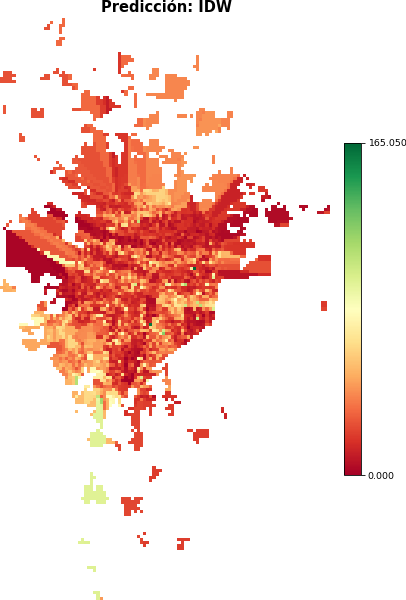

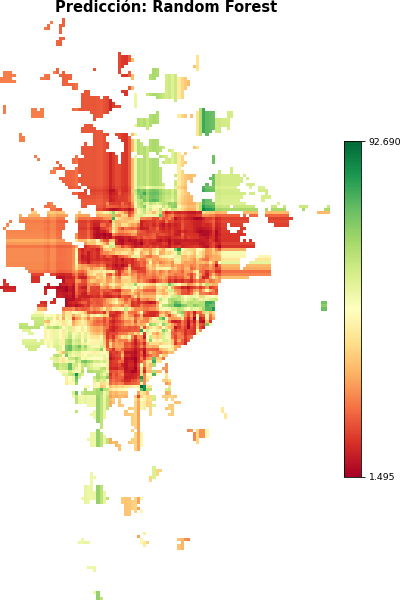

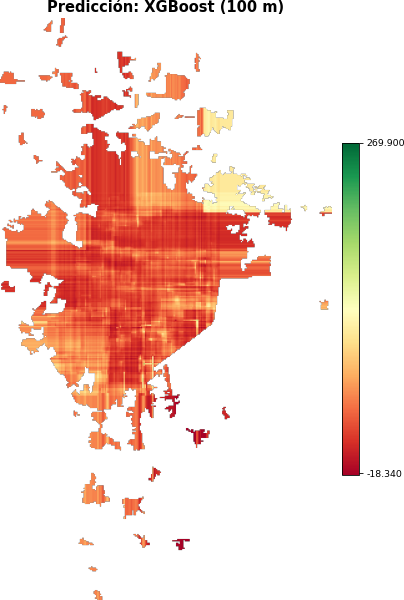

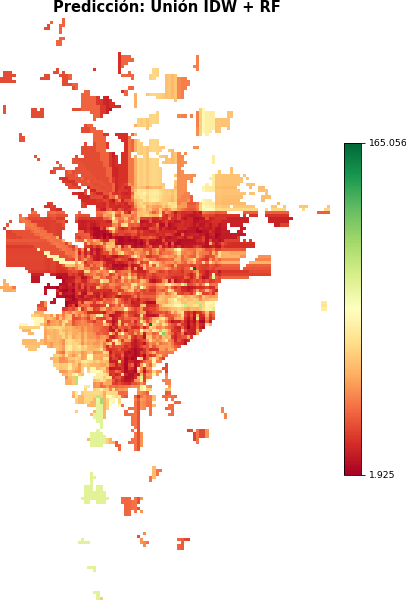

In [7]:
import os, glob, math, json, textwrap
import numpy as np
import rasterio
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPyImage

print("Backend matplotlib:", matplotlib.get_backend())
print("Directorio de trabajo:", os.getcwd())

# Métodos
candidatos = [
    ("IDW",             "pred_IDW_Merida.tif"),
    ("Random Forest",   "pred_RF_Merida.tif"),
    ("XGBoost (100 m)", "pred_XGB_100m_Merida.tif"),
    ("Unión IDW + RF",  "union_IDW_RF_Merida.tif"),
]
encontrados = [(m, p) for (m, p) in candidatos if os.path.exists(p)]
if not encontrados:
    print("No se encontró ningún GeoTIFF esperado en el cwd.")
    print("Archivos .tif presentes:", glob.glob("*.tif"))
    print("Sugerencia: ejecuta primero main() y revisa que el cwd sea donde se crean los archivos.")
else:
    print("Encontré:", [p for _, p in encontrados])

limites_personalizados = {
    "pred_IDW_Merida.tif": (0.0, 165.05),
    "pred_RF_Merida.tif": (1.495, 92.69),
    "union_IDW_RF_Merida.tif": (1.925, 165.056),
    "pred_XGB_100m_Merida.tif": (-18.34, 269.9),
}

def _autosize_title(title_text, base_size=14):
    """Disminuye el tamaño si el título es largo, para que quepa bien en 8x8."""
    L = len(title_text or "")
    if L <= 60:
        return base_size
    return max(10, base_size - ((L - 60) // 10))

def _render_png(raster_path, out_png, cmap_name="RdYlGn",
                vmin=None, vmax=None, figsize=(8,8), dpi=220, title=None):
    with rasterio.open(raster_path) as src:
        data = src.read(1).astype("float32")
        if src.nodata is not None and np.isfinite(src.nodata):
            data = np.where(np.isclose(data, src.nodata, equal_nan=False), np.nan, data)

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.gca()
    ax.set_axis_off()

    cmap = matplotlib.colormaps[cmap_name]

    if vmin is not None and vmax is not None:
        im = ax.imshow(data, cmap=cmap, vmin=vmax, vmax=vmin)
    else:
        vals = data[np.isfinite(data)]
        if vals.size > 0:
            lo, hi = np.nanpercentile(vals, 2), np.nanpercentile(vals, 98)
            im = ax.imshow(data, cmap=cmap, vmin=hi, vmax=lo)
        else:
            im = ax.imshow(data, cmap=cmap)

    cbar = plt.colorbar(im, ax=ax, fraction=0.030, pad=0.02)
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([f"{vmin:.3f}", f"{vmax:.3f}"])
    cbar.ax.tick_params(labelsize=9)

    if title:
        wrapped = textwrap.fill(title, width=90)
        fs = _autosize_title(title, base_size=14)
        plt.title(wrapped, fontsize=fs, weight="bold", pad=6)

    plt.tight_layout(pad=0)
    fig.savefig(out_png, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

TIT_TEMPLATE = "Predicción: {metodo}"
for metodo, tif in encontrados:
    png = os.path.splitext(tif)[0] + "_preview.png"
    title = TIT_TEMPLATE.format(metodo=metodo)
    vmin, vmax = limites_personalizados.get(tif, (None, None))
    _render_png(
        tif, png,
        cmap_name="RdYlGn",
        vmin=vmin,
        vmax=vmax,
        figsize=(8,8),
        dpi=75,
        title=title
    )
    display(IPyImage(filename=png))
